Checking stationarity for 'open_price':
ADF Statistic: -1.569693
p-value: 0.498797
Series is not stationary
Checking stationarity for 'open_price' after differencing:
ADF Statistic: -6.399604
p-value: 0.000000
Series is stationary
Monthly Data Analysis:
Distribution Plot:


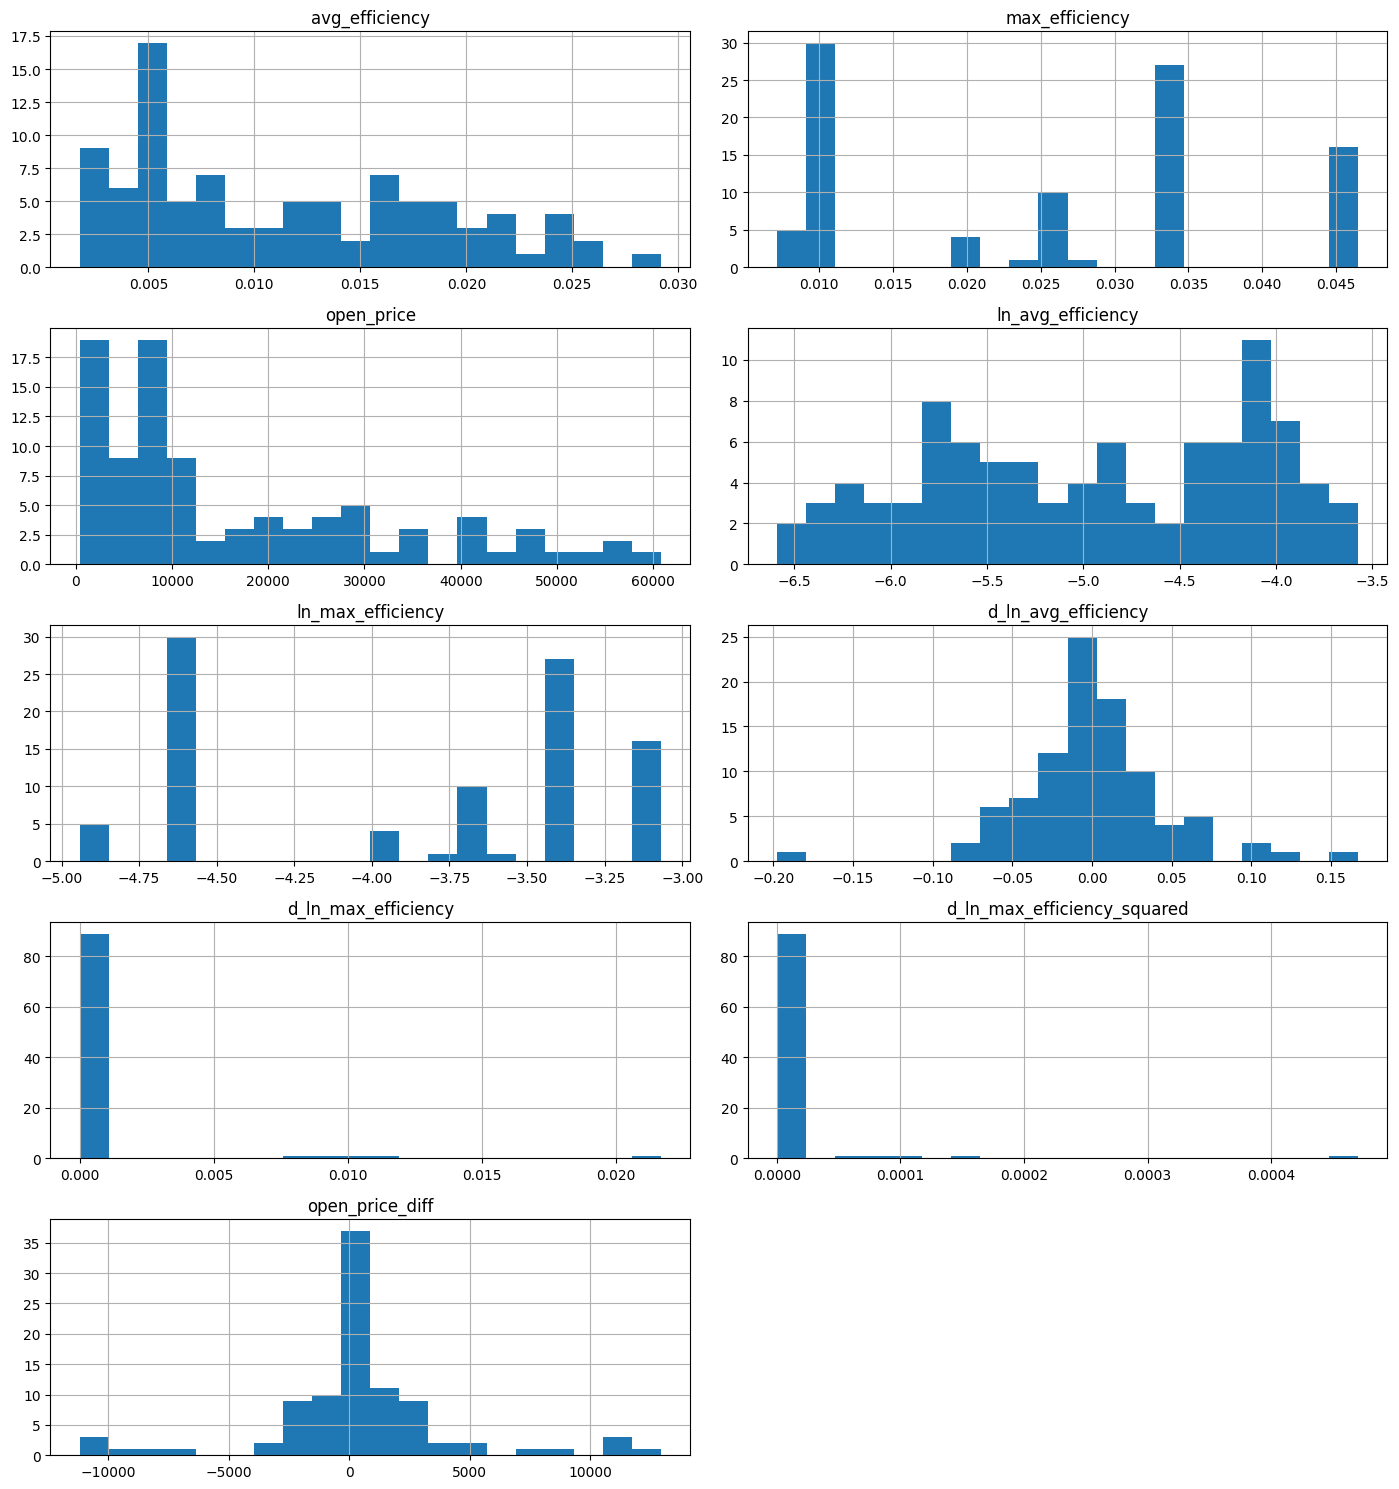

Summary Statistics:
                             count          mean           std           min  \
avg_efficiency                94.0      0.011509      0.007137      0.001752   
max_efficiency                94.0      0.025381      0.013832      0.007140   
open_price                    94.0  16385.551610  16087.175123    402.031379   
ln_avg_efficiency             94.0     -4.944944      0.830464     -6.590701   
ln_max_efficiency             94.0     -3.856147      0.640804     -4.942043   
d_ln_avg_efficiency           94.0      0.001018      0.045641     -0.197860   
d_ln_max_efficiency           94.0      0.000650      0.002981      0.000000   
d_ln_max_efficiency_squared   94.0      0.000009      0.000052      0.000000   
open_price_diff               94.0    305.620651   3970.141309 -11177.666621   

                                     25%          50%           75%  \
avg_efficiency                  0.005259     0.009966      0.017204   
max_efficiency                  0.010

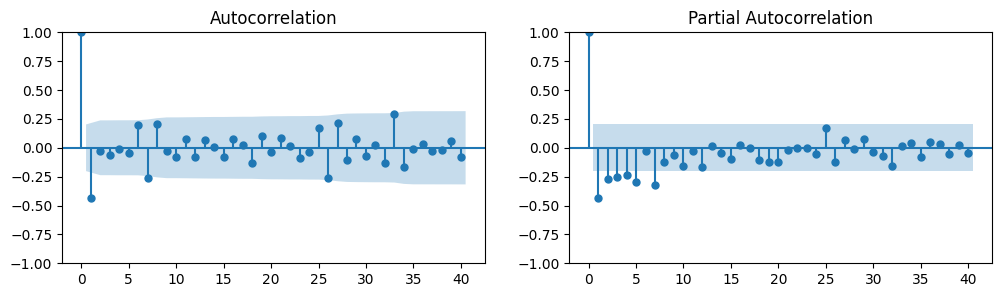

ACF and PACF Plots for d_ln_max_efficiency:


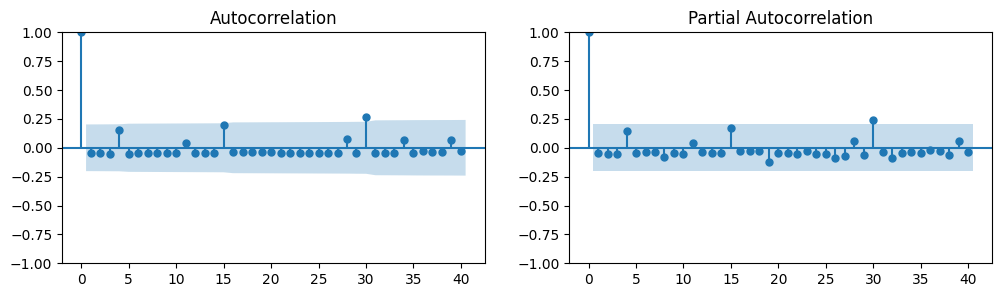

Weekly Data Analysis:
Distribution Plot:


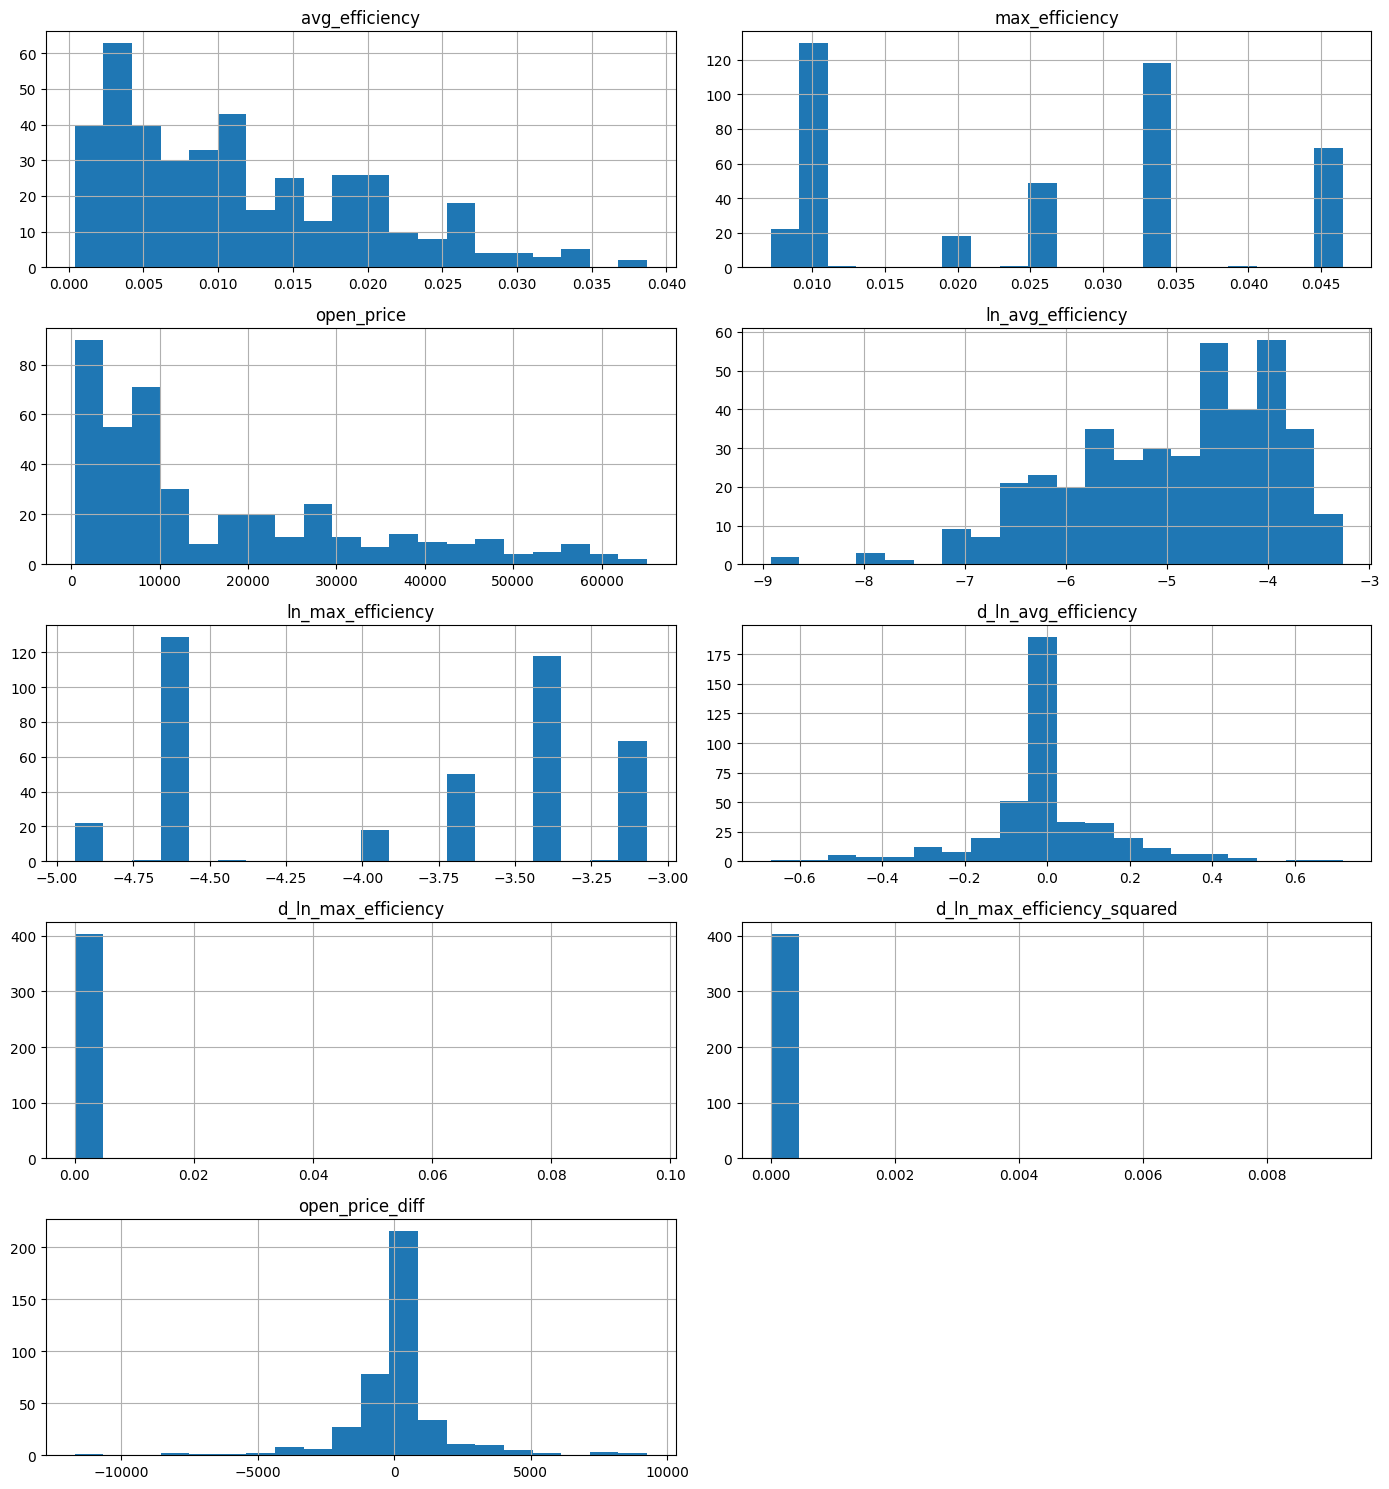

Summary Statistics:
                             count          mean           std           min  \
avg_efficiency               409.0      0.011496      0.008389      0.000400   
max_efficiency               409.0      0.025350      0.013782      0.007140   
open_price                   409.0  16343.405654  16111.769891    376.983571   
ln_avg_efficiency            409.0     -4.946557      1.034660     -8.919969   
ln_max_efficiency            409.0     -3.857883      0.638917     -4.942043   
d_ln_avg_efficiency          409.0      0.001415      0.162869     -0.670242   
d_ln_max_efficiency          409.0      0.000654      0.006371      0.000000   
d_ln_max_efficiency_squared  409.0      0.000041      0.000494      0.000000   
open_price_diff              409.0     80.515152   1864.247332 -11707.349277   

                                     25%          50%           75%  \
avg_efficiency                  0.004224     0.009583      0.017759   
max_efficiency                  0.010

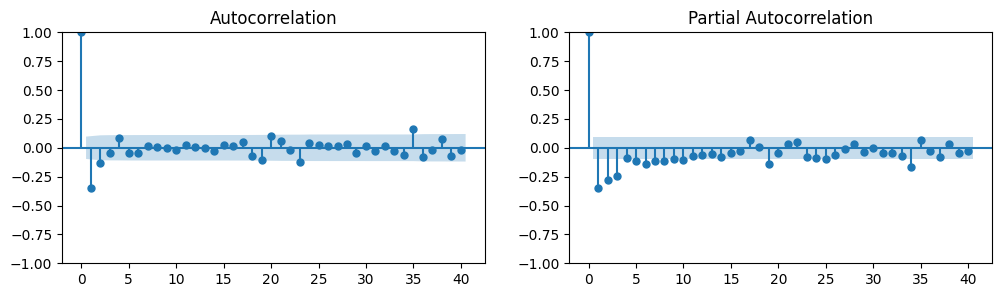

ACF and PACF Plots for d_ln_max_efficiency:


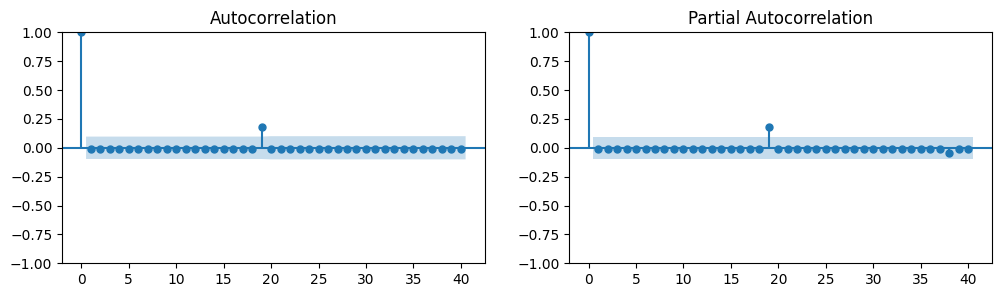

Daily Data Analysis:
Distribution Plot:


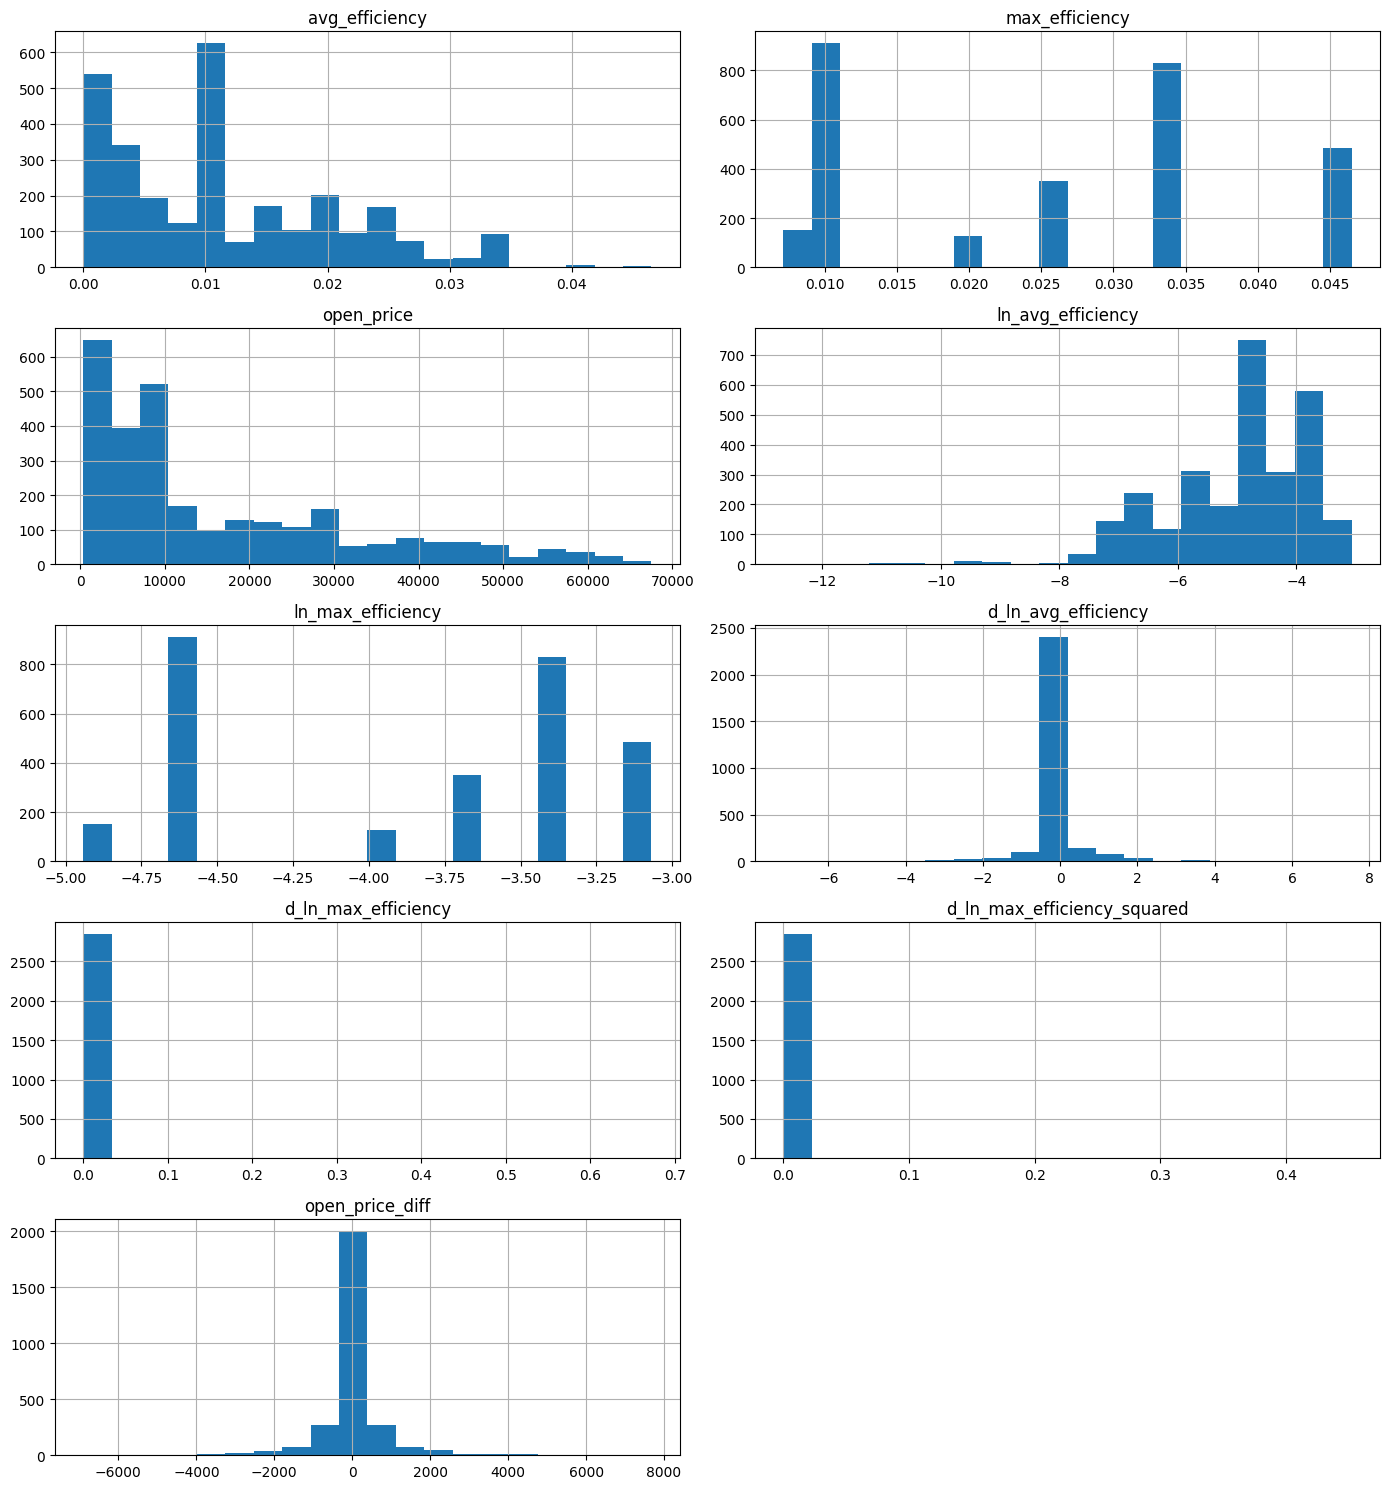

Summary Statistics:
                              count          mean           std          min  \
avg_efficiency               2859.0      0.011508      0.009145     0.000003   
max_efficiency               2859.0      0.025375      0.013766     0.007140   
open_price                   2859.0  16365.666061  16122.285042   364.331000   
ln_avg_efficiency            2859.0     -4.944968      1.188963   -12.657812   
ln_max_efficiency            2859.0     -3.856366      0.637689    -4.942043   
d_ln_avg_efficiency          2859.0      0.001008      0.699106    -7.163968   
d_ln_max_efficiency          2859.0      0.000655      0.016926     0.000000   
d_ln_max_efficiency_squared  2859.0      0.000287      0.009177     0.000000   
open_price_diff              2859.0     11.767044    845.517217 -6901.783336   

                                     25%          50%           75%  \
avg_efficiency                  0.003829     0.010193      0.018182   
max_efficiency                  0.010

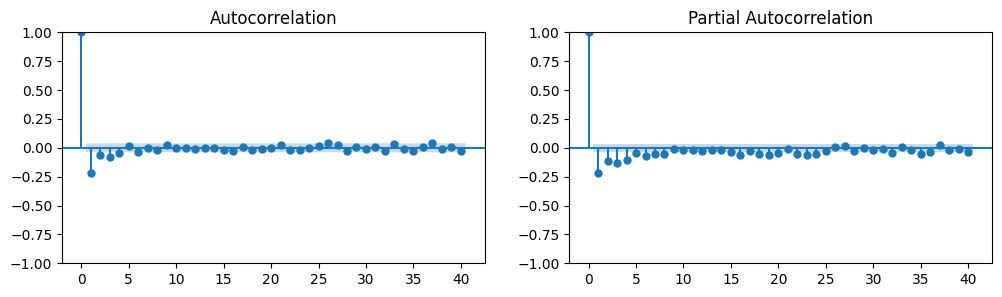

ACF and PACF Plots for d_ln_max_efficiency:


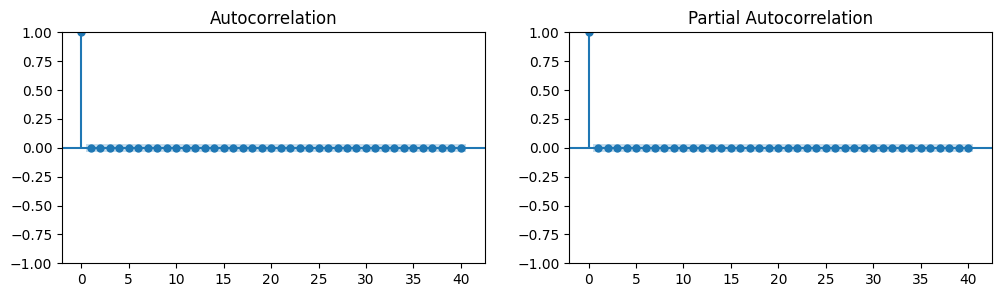

Monthly Data Model Estimation:


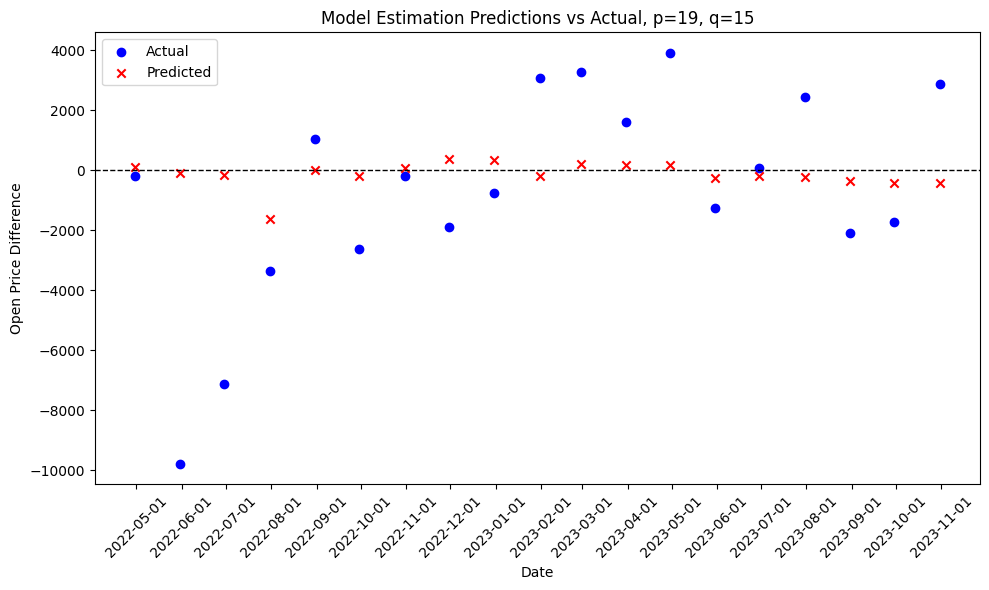

Model Estimation Results:
    p   q          MAE           MSE         RMSE       AIC         BIC  \
0  19  15  2501.976366  1.147625e+07  3387.661154  98.30274  188.161279   

      Ljung-Box  Durbin-Watson   Jarque-Bera  Shapiro-Wilk  White Test  
0  7.180382e-09       1.071956  3.772150e-09  6.417748e-09    0.985646  
Best Model:
p                1.900000e+01
q                1.500000e+01
MAE              2.501976e+03
MSE              1.147625e+07
RMSE             3.387661e+03
AIC              9.830274e+01
BIC              1.881613e+02
Ljung-Box        7.180382e-09
Durbin-Watson    1.071956e+00
Jarque-Bera      3.772150e-09
Shapiro-Wilk     6.417748e-09
White Test       9.856456e-01
Name: 0, dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates

# Read the input data from the CSV file
data = pd.read_csv('inputs.csv', parse_dates=['date']) # date,avg_efficiency,max_efficiency,open_price

# keep only data after 2016
data = data[data['date'] >= '2016-01-01']

# Calculate the derivative of ln avg_efficiency and ln max_efficiency per day
data['ln_avg_efficiency'] = np.log(data['avg_efficiency'].replace(0, np.nan))
data['ln_max_efficiency'] = np.log(data['max_efficiency'].replace(0, np.nan))
data['d_ln_avg_efficiency'] = data['ln_avg_efficiency'].diff()
data['d_ln_max_efficiency'] = data['ln_max_efficiency'].diff()

# Fill NaN values after computing differences
data.fillna(method='bfill', inplace=True)

# Create monthly averages
monthly_data = data.resample('M', on='date').mean()

# Create weekly averages
weekly_data = data.resample('W', on='date').mean()

# Keep daily data
daily_data = data

# Ensure no infinite values are present
monthly_data.replace([np.inf, -np.inf], np.nan, inplace=True)
weekly_data.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any remaining NaN values that might disrupt the model fitting
monthly_data.ffill(inplace=True)
weekly_data.ffill(inplace=True)
daily_data.ffill(inplace=True)

# Add squared max_efficiency derivative for model estimation
monthly_data['d_ln_max_efficiency_squared'] = monthly_data['d_ln_max_efficiency'] ** 2
weekly_data['d_ln_max_efficiency_squared'] = weekly_data['d_ln_max_efficiency'] ** 2
daily_data['d_ln_max_efficiency_squared'] = daily_data['d_ln_max_efficiency'] ** 2

# Function to perform exploratory data analysis
def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    numeric_df = df.select_dtypes(include=[np.number])
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    print(summary)

    for col in ['d_ln_avg_efficiency', 'd_ln_max_efficiency']:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=40, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=40, ax=axes[1])
            plt.show()

from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

# Example of checking stationarity for the 'open_price' series
print("Checking stationarity for 'open_price':")
check_stationarity(monthly_data['open_price'])

# Differencing the series to make it stationary
monthly_data['open_price_diff'] = monthly_data['open_price'].diff().fillna(method='bfill')
weekly_data['open_price_diff'] = weekly_data['open_price'].diff().fillna(method='bfill')
daily_data['open_price_diff'] = daily_data['open_price'].diff().fillna(method='bfill')

# Re-check stationarity after differencing
print("Checking stationarity for 'open_price' after differencing:")
check_stationarity(monthly_data['open_price_diff'])

# Adjust the model estimation to use the differenced series
def model_estimation(df, p_range, q_range, title='Model Estimation'):
    results = []
    train_size = int(len(df) * 0.8)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Add a constant column to the exogenous variables
    train_exog = sm.add_constant(train_data[['d_ln_avg_efficiency', 'd_ln_max_efficiency', 'd_ln_max_efficiency_squared']])
    test_exog = sm.add_constant(test_data[['d_ln_avg_efficiency', 'd_ln_max_efficiency', 'd_ln_max_efficiency_squared']])

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(train_data['open_price_diff'], order=(p, 1, q), exog=train_exog)
                model_fit = model.fit()
                
                predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

                mae = mean_absolute_error(test_data['open_price_diff'], predictions)
                mse = mean_squared_error(test_data['open_price_diff'], predictions)
                rmse = np.sqrt(mse)
                aic = model_fit.aic
                bic = model_fit.bic
                
                # Test residuals for autocorrelation, normality, and heteroscedasticity
                residuals = model_fit.resid
                
                # Autocorrelation tests
                ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
                durbin_watson = sm.stats.durbin_watson(residuals)
                
                # Normality tests
                jarque_bera = sm.stats.jarque_bera(residuals)
                shapiro_wilk = shapiro(residuals)
                
                # Heteroscedasticity test
                white_test = sm.stats.het_white(residuals, model_fit.model.exog)
                
                results.append({
                    'p': p, 'q': q, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
                    'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
                    'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
                    'White Test': white_test[1]
                })

                # Plotting the predictions against the actual values
                plt.figure(figsize=(10, 6))
                plt.scatter(test_data.index, test_data['open_price_diff'], label='Actual', color='blue', marker='o')
                plt.scatter(test_data.index, predictions, label='Predicted', color='red', marker='x')
                plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
                plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
                plt.xlabel('Date')
                plt.ylabel('Open Price Difference')
                plt.legend()
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error with ARIMA({p},1,{q}): {e}")
    
    results_df = pd.DataFrame(results)
    print("Model Estimation Results:")
    print(results_df)
    
    best_model = results_df.loc[results_df['MAE'].idxmin()]
    print("Best Model:")
    print(best_model)


# Perform exploratory data analysis
print("Monthly Data Analysis:")
exploratory_analysis(monthly_data)

print("Weekly Data Analysis:")
exploratory_analysis(weekly_data)

print("Daily Data Analysis:")
exploratory_analysis(daily_data)

import warnings
warnings.filterwarnings("ignore")


# Perform model estimation process
print("Monthly Data Model Estimation:")
monthly_data['d_ln_max_efficiency_squared'] = monthly_data['d_ln_max_efficiency'] ** 2
# model_estimation(monthly_data, range(0, 13), range(0, 13))
# model_estimation(monthly_data, range(1, 20, 2), range(1, 20, 2), title='Monthly Data')
model_estimation(monthly_data, [19], [15])
# model_estimation(monthly_data, [8], [6])

# print("Weekly Data Model Estimation:")
# weekly_data['d_ln_max_efficiency_squared'] = weekly_data['d_ln_max_efficiency'] ** 2
# model_estimation(weekly_data, range(0, 51), range(0, 51))
# model_estimation(weekly_data, range(0, 20, 2), range(0, 20, 2), title='Weekly Data')
# model_estimation(weekly_data, [6], [1])

# print("Daily Data Model Estimation:")
# daily_data['d_ln_max_efficiency_squared'] = daily_data['d_ln_max_efficiency'] ** 2
# # model_estimation(daily_data, range(0, 361), range(0, 361))
# model_estimation(daily_data, [1], [1])